In [1]:
# imports for the project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

## Introduction
This code leverages OpenCV for optical tracking on images extracted from a video source. It identifies key points of an object, calculates their motion across consecutive frames, and estimates their 3D spatial positions using computer vision techniques.

## Helper Functions

Assistance function for sketching lines and generating the object's drawing.

In [2]:
# Definition of the function to obtain adjacent nodes to a given node on a cube
def adjacent_nodes(node):
    adjacency_map = {
        1: [2, 5, 4],
        2: [1, 3, 6],
        3: [2, 4, 7],
        4: [1, 3, 8],
        5: [1, 6, 8],
        6: [2, 5, 7],
        7: [3, 6, 8],
        8: [4, 5, 7]
    }
    return adjacency_map[node]

pairs = []
for node in [1, 3, 6, 8]:
    for adj_node in adjacent_nodes(node):
        pairs.append((node, adj_node))

# Definition of the function to draw a line between two points on an image
def draw_line(frame, p1, p2):
    image = frame.copy()
    x1, y1 = p1.ravel().astype(int)
    x2, y2 = p2.ravel().astype(int)
    # Drawing the line in BGR color (green)
    cv2.line(image, (x1, y1), (x2, y2), (51, 255, 51), 2)
    return image

# Definition of the function to draw nodes and lines on an image
def paint_frame(frame, coordinates):
    image = frame.copy()
    for point in coordinates:
        x, y = point.ravel().astype(int)
        cv2.circle(image, (x, y), 5, (0, 0, 255), -1)
    
    for pair in pairs:
        p1 = coordinates[pair[0] - 1]
        p2 = coordinates[pair[1] - 1]
        image = draw_line(image, p1, p2)

    return image

# Definition of the function to save a series of images as a video
def save_as_video(saved_frames, output_video_path):
    # Get the dimensions of the images
    height, width, _ = saved_frames[0].shape

    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Change the codec if necessary
    out = cv2.VideoWriter(output_video_path, fourcc, 25.0, (width, height))  # Adjust the frame rate if necessary (here 25.0)

    for frame in saved_frames:
        out.write(frame)

    out.release()

## Camera and object axis

In [3]:
# Definition of constants

# Camera matrix
camera_matrix = np.array(
    [[606.209, 0, 320.046], [0, 606.719, 238.926], [0, 0, 1]], np.float32
)

# Distortion coefficients
dist_coeffs = np.array([[0, 0, 0, 0, 0]], np.float32)

# 3D coordinates of the object on the real plane
object_points = (
    np.array(
        [
            [0, 90, 0],
            [125, 90, 0],
            [125, 90, 70],
            [0, 90, 70],
            [0, 0, 0],
            [125, 0, 0],
            [125, 0, 70],
            [0, 0, 70],
        ],
        np.float32,
    ).reshape((-1, 1, 3))
) * 1e-3  # Scaling to meters

## Video axis 
we use [mousse_track.py] and select the corners defined in the image below

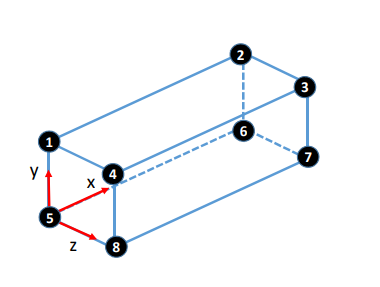

In [4]:
# Definition of initial points using mouse_tracker.py [auxiliary program]
p0 = np.array(
    [
        [[219., 176.]],#1
        [[414., 176.]],#2
        [[443., 244.]],#3
        [[208., 247.]],#4
        [[226., 286.]],#5
        [[424., 286.]],#6
        [[425., 363.]],#7
        [[223., 363.]],#8
    ],
    dtype=np.float32,
)

points_to_take = [0, 1, 2, 3, 6, 7]
estimated_points = p0[points_to_take]

object_points_reduced = object_points[points_to_take]

## Object tracking algorithm


In this section we stores the first frame and then, for subsequent frames, it calculates optical flow to track specific points between consecutive frames. Using the tracked points, it estimates the pose of a known object in the video. This pose estimation allows for projecting specific points onto the frames, aiding in visualizing and drawing lines on the video frames.

In [5]:
saved_frames = []  # List to store processed frames
video_path = 'video/box_video_data.avi'  # Replace this with the path to your video file
cap = cv2.VideoCapture(video_path)  # Capturing video from the specified path

start_box = 3  # Starting frame for analysis
i = 0
while True:
    ret, frame = cap.read()  # Read each frame from the video
    if not ret:
        break  # Break the loop if no frame is retrieved

    if i == start_box:
        prev_image = frame  # Store the previous image for optical tracking
        tmp_frame = frame  # Use the raw image for the first frame
        saved_frames.append(tmp_frame)  # Store the image in the list of saved frames
    elif i > start_box:
        next_image = frame  # Next image for optical tracking
        # Convert to grayscale for optical tracking
        prev_image = cv2.cvtColor(prev_image, cv2.COLOR_BGR2GRAY)
        next_image = cv2.cvtColor(next_image, cv2.COLOR_BGR2GRAY)
        # Calculate optical flow of points
        next_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_image, next_image, estimated_points, None)
        # Solve PnP to obtain pose
        retval, rvec, tvec = cv2.solvePnP(object_points_reduced, next_pts, camera_matrix, dist_coeffs)
        # Project points onto the image
        image_points, _ = cv2.projectPoints(object_points, rvec, tvec, camera_matrix, dist_coeffs)
        tmp_frame = paint_frame(frame, image_points)  # Draw lines and points on the image
        prev_image = frame  # Update the previous image
        estimated_points = np.array(image_points[points_to_take], dtype=np.float32).reshape(estimated_points.shape)  # Update points for the next iteration
        saved_frames.append(tmp_frame)  # Store the image in the list of saved frames

    i += 1  # Increment the frame index

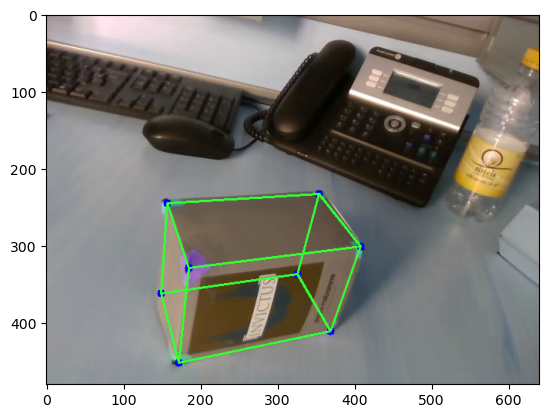

In [6]:
plt.imshow(saved_frames[100], cmap='gray')

## Saving the video

In [7]:
output_video_path = 'output/traced_video_4pts.mp4'
save_as_video(saved_frames, output_video_path)